
ENSEMBLE QDA + RF FOR Primary


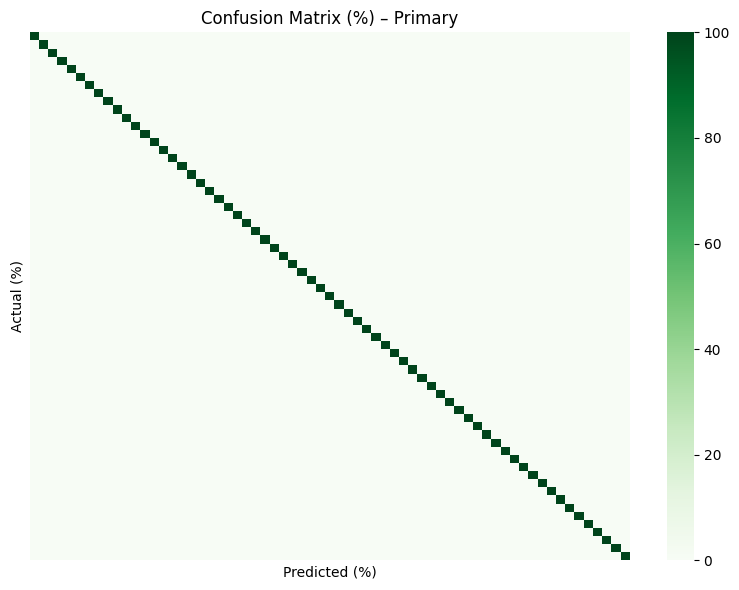

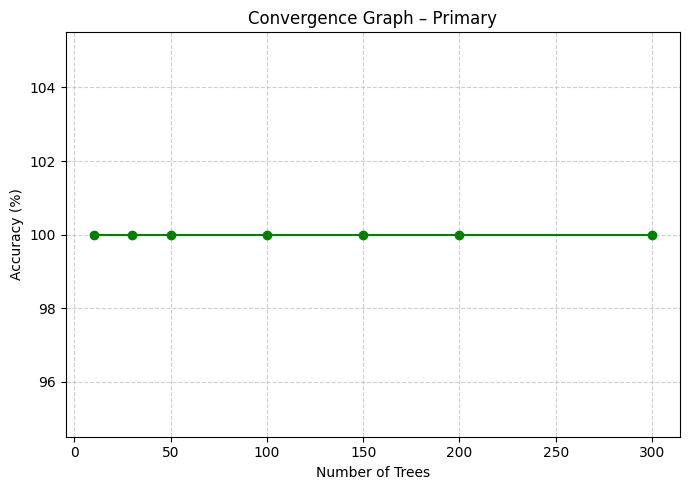


ENSEMBLE QDA + RF FOR Fault Location


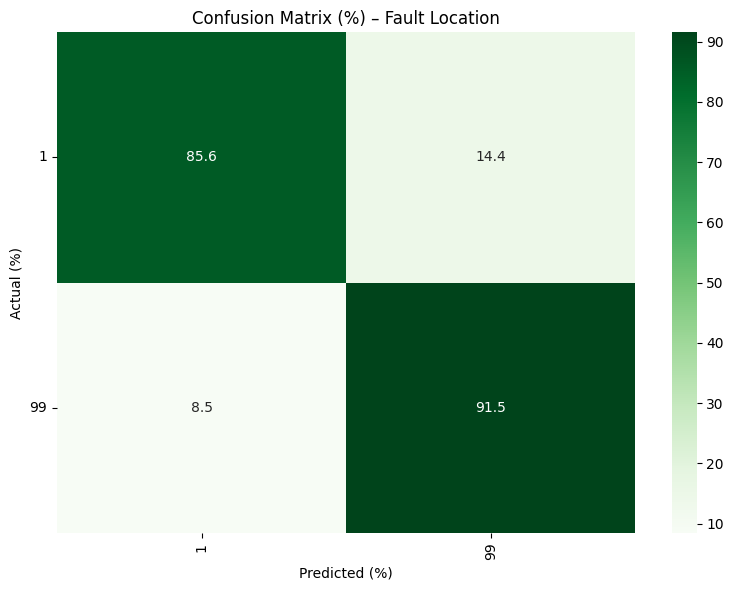

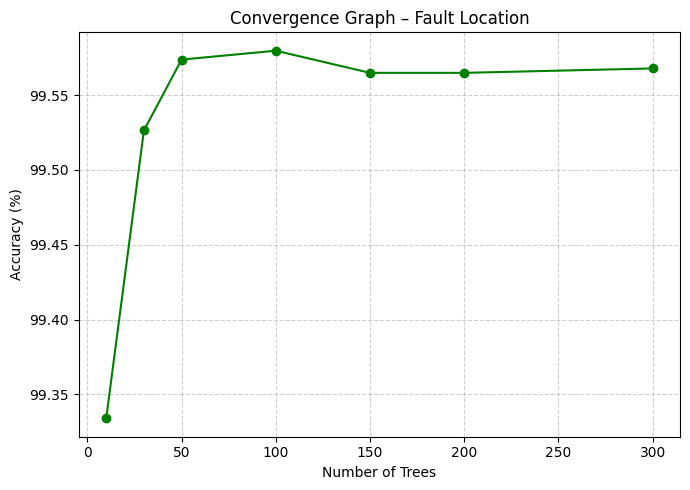


ENSEMBLE QDA + RF FOR Fault Line


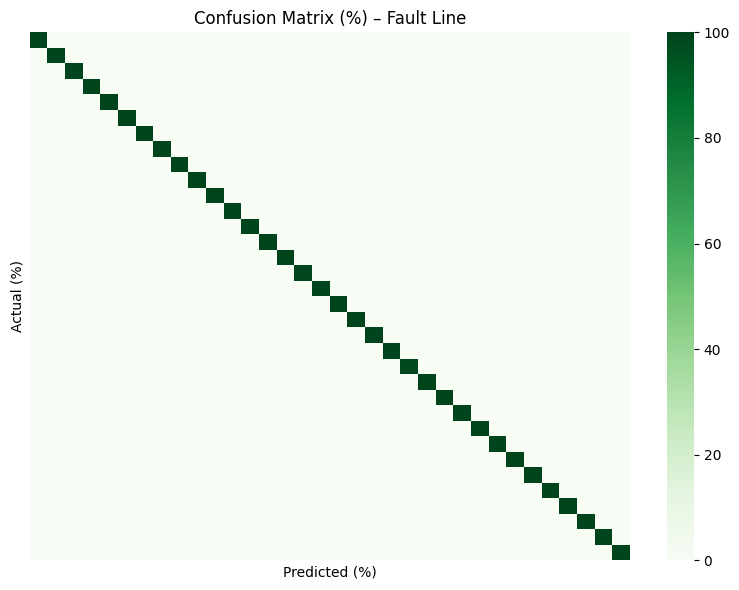

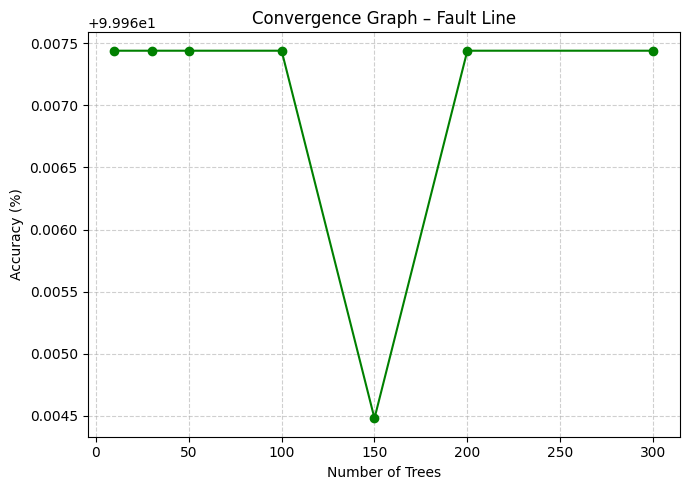


ENSEMBLE QDA + RF FOR CCT_Class


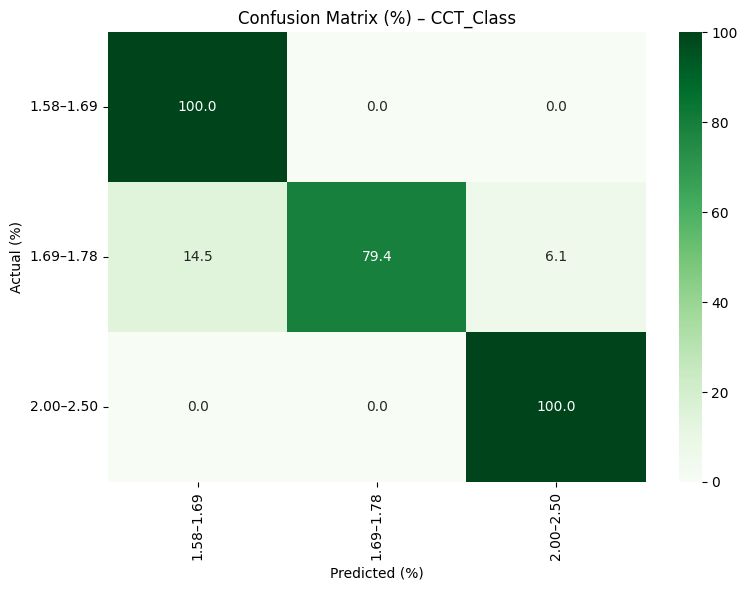

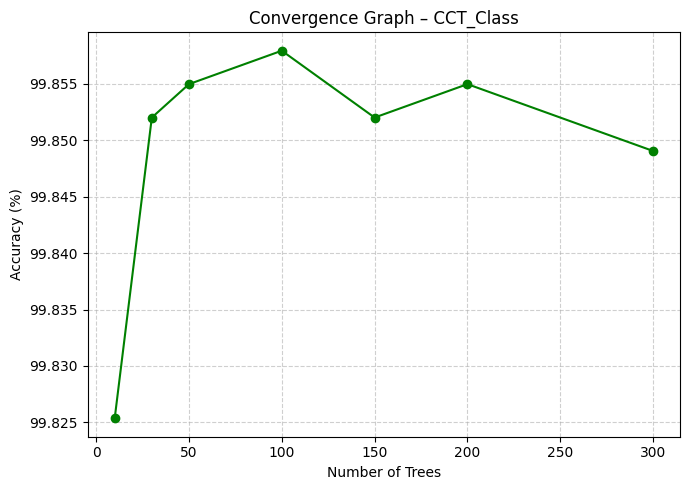

In [12]:
for label in LABELS:

    print("\n============================================")
    print(f"ENSEMBLE QDA + RF FOR {label}")
    print("============================================")

    le = LabelEncoder()
    y = le.fit_transform(df[label])

    if len(np.unique(y)) < 2:
        print("❌ Only one class present — skipping")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    # QDA
    qda = QuadraticDiscriminantAnalysis(reg_param=0.5)
    qda.fit(X_train, y_train)
    qda_prob = qda.predict_proba(X_test)

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_prob = rf.predict_proba(X_test)

    # Ensemble
    alpha = ALPHA[label]
    ensemble_prob = alpha * qda_prob + (1 - alpha) * rf_prob
    y_pred = np.argmax(ensemble_prob, axis=1)

    # -------------------------------
    # CONFUSION MATRIX (PERCENTAGE)
    # -------------------------------
    class_names = get_class_names(label, le)

    plot_confusion_matrix_percent(
        y_test,
        y_pred,
        class_names,
        title=f"Confusion Matrix (%) – {label}"
    )

    # -------------------------------
    # CONVERGENCE GRAPH
    # -------------------------------
    tree_range = [10, 30, 50, 100, 150, 200, 300]
    acc_scores = []

    for n in tree_range:
        rf_tmp = RandomForestClassifier(
            n_estimators=n,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )
        rf_tmp.fit(X_train, y_train)
        acc_scores.append(
            accuracy_score(y_test, rf_tmp.predict(X_test)) * 100
        )

    plot_convergence(
        tree_range,
        acc_scores,
        title=f"Convergence Graph – {label}"
    )

In [12]:
import pandas as pd
import numpy as np
import warnings
import os                       # ✅ ADD THIS

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error,
    confusion_matrix
)

In [24]:
# ==================================================
# LOAD DATA
# ==================================================
FILE_PATH = r"E:\WOU_BITS INTERN\39 BUS SYSTEM\39 BUS SYSTEM_FAULT_CONVERTED.xlsx"
df = pd.read_excel(FILE_PATH)

In [25]:
# ==================================================
# BASE FEATURES
# ==================================================
BASE_FEATURES = [
    "Phase Voltage A/Terminal in kV",
    "Phase Voltage B/Terminal in kV",
    "Phase Voltage C/Terminal in kV",
    "Phase Current A/Terminal in kA",
    "Phase Current B/Terminal in kA",
    "Phase Current C/Terminal in kA",
    "Terminal/Bus"
]

# ==================================================
# CCT BINNING
# ==================================================
cct_bins = [1.58, 1.69, 1.78, 2.00, 2.50]
cct_labels = ["1.58–1.69", "1.69–1.78", "1.78–2.00", "2.00–2.50"]

df["CCT_Class"] = pd.cut(
    df["CCT"],
    bins=cct_bins,
    labels=cct_labels,
    include_lowest=True
)

# ==================================================
# LABELS
# ==================================================
LABELS = ["Primary", "Fault Location", "Fault Line", "CCT_Class"]

# ==================================================
# DROP MISSING VALUES
# ==================================================
df = df[BASE_FEATURES + LABELS].dropna()

# ==================================================Q
# ONE-HOT ENCODING
# ==================================================
df = pd.get_dummies(df, columns=["Terminal/Bus"], drop_first=True)

# ==================================================
# FINAL FEATURES
# ==================================================
FEATURES = [c for c in df.columns if c not in LABELS]

# ==================================================
# FEATURE SCALING
# ==================================================
scaler = StandardScaler()
X = scaler.fit_transform(df[FEATURES])

print("\n🤖 AUTOMATIC MODEL SELECTION: QDA vs RF vs ENSEMBLE")
print("===================================================")

final_summary = {}


🤖 AUTOMATIC MODEL SELECTION: QDA vs RF vs ENSEMBLE


In [9]:
# ==================================================
# LOOP FOR EACH LABEL
# ==================================================
for label in LABELS:

    print("\n-----------------------------------------------")
    print(f"LABEL: {label}")
    print("-----------------------------------------------")

    y = LabelEncoder().fit_transform(df[label])

    if len(np.unique(y)) < 2:
        print("❌ Only one class present — skipped")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    # ---------------------------------------------
    # QDA MODEL
    # ---------------------------------------------
    qda = QuadraticDiscriminantAnalysis(reg_param=0.8)
    qda.fit(X_train, y_train)
    qda_prob = qda.predict_proba(X_test)
    qda_pred = np.argmax(qda_prob, axis=1)

    acc_qda = accuracy_score(y_test, qda_pred) * 100

    # ---------------------------------------------
    # RANDOM FOREST MODEL
    # ---------------------------------------------
    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_prob = rf.predict_proba(X_test)
    rf_pred = np.argmax(rf_prob, axis=1)

    acc_rf = accuracy_score(y_test, rf_pred) * 100

    # ---------------------------------------------
    # ENSEMBLE (AUTO α SEARCH)
    # ---------------------------------------------
    best_alpha = None
    best_ens_acc = 0
    best_ens_prob = None
    best_ens_pred = None

    for alpha in np.arange(0.1, 1.0, 0.1):
        ens_prob = alpha * qda_prob + (1 - alpha) * rf_prob
        ens_pred = np.argmax(ens_prob, axis=1)
        acc = accuracy_score(y_test, ens_pred) * 100

        if acc > best_ens_acc:
            best_ens_acc = acc
            best_alpha = alpha
            best_ens_prob = ens_prob
            best_ens_pred = ens_pred

    # ---------------------------------------------
    # MODEL SELECTION
    # ---------------------------------------------
    scores = {
        "QDA": acc_qda,
        "Random Forest": acc_rf,
        "Ensemble": best_ens_acc
    }

    best_model = max(scores, key=scores.get)

    # ---------------------------------------------
    # FINAL METRICS (BEST MODEL ONLY)
    # ---------------------------------------------
    if best_model == "QDA":
        y_pred = qda_pred
        y_prob = qda_prob
    elif best_model == "Random Forest":
        y_pred = rf_pred
        y_prob = rf_prob
    else:
        y_pred = best_ens_pred
        y_prob = best_ens_prob

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average="weighted") * 100
    rec = recall_score(y_test, y_pred, average="weighted") * 100
    f1 = f1_score(y_test, y_pred, average="weighted") * 100
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr") * 100
    except:
        roc_auc = None

    # ---------------------------------------------
    # PRINT RESULTS
    # ---------------------------------------------
    print(f"QDA Accuracy        : {acc_qda:.2f}%")
    print(f"RF Accuracy         : {acc_rf:.2f}%")
    print(f"Ensemble Accuracy   : {best_ens_acc:.2f}% (alpha={best_alpha})")
    print(f"✅ SELECTED MODEL   : {best_model}")

    print("\n--- FINAL METRICS (Selected Model) ---")
    print(f"Accuracy (%)   : {acc:.2f}")
    print(f"Precision (%)  : {prec:.2f}")
    print(f"Recall (%)     : {rec:.2f}")
    print(f"F1-score (%)   : {f1:.2f}")
    print(f"ROC-AUC (%)    : {roc_auc:.2f}" if roc_auc else "ROC-AUC : Not defined")
    print(f"MAE            : {mae:.4f}")
    print(f"MSE            : {mse:.4f}")
    print(f"RMSE           : {rmse:.4f}")

    final_summary[label] = {
        "Best Model": best_model,
        "QDA Acc": acc_qda,
        "RF Acc": acc_rf,
        "ENS Acc": best_ens_acc
    }

# ==================================================
# FINAL SUMMARY
# ==================================================
print("\n🎯 FINAL MODEL SELECTION SUMMARY")
print("================================")
for lbl, res in final_summary.items():
    print(
        f"{lbl:15s} → {res['Best Model']:12s} | "
        f"QDA={res['QDA Acc']:.2f}% | "
        f"RF={res['RF Acc']:.2f}% | "
        f"ENS={res['ENS Acc']:.2f}%"
    )

print("\n✅ AUTOMATIC QDA / RF / ENSEMBLE SELECTION COMPLETED")


-----------------------------------------------
LABEL: Primary
-----------------------------------------------
QDA Accuracy        : 100.00%
RF Accuracy         : 100.00%
Ensemble Accuracy   : 100.00% (alpha=0.1)
✅ SELECTED MODEL   : QDA

--- FINAL METRICS (Selected Model) ---
Accuracy (%)   : 100.00
Precision (%)  : 100.00
Recall (%)     : 100.00
F1-score (%)   : 100.00
ROC-AUC (%)    : 100.00
MAE            : 0.0000
MSE            : 0.0000
RMSE           : 0.0000

-----------------------------------------------
LABEL: Fault Location
-----------------------------------------------
QDA Accuracy        : 50.09%
RF Accuracy         : 99.57%
Ensemble Accuracy   : 99.58% (alpha=0.1)
✅ SELECTED MODEL   : Ensemble

--- FINAL METRICS (Selected Model) ---
Accuracy (%)   : 99.58
Precision (%)  : 99.58
Recall (%)     : 99.58
F1-score (%)   : 99.58
ROC-AUC : Not defined
MAE            : 0.0042
MSE            : 0.0042
RMSE           : 0.0651

-----------------------------------------------
LABEL:

In [32]:
label

'CCT'

In [28]:
# ==================================================
# OUTPUT DIRECTORY SETUP
# ==================================================
import os

BASE_DIR = os.path.dirname(FILE_PATH)
OUT_DIR = os.path.join(BASE_DIR, "QDA+RF", "DASHBOARD")

os.makedirs(OUT_DIR, exist_ok=True)

In [30]:
# ==================================================
# DASHBOARD PLOTS & SAVING
# ==================================================
label_dir = os.path.join(OUT_DIR, label.replace(" ", "_"))
os.makedirs(label_dir, exist_ok=True)

models = {
    "QDA": (qda_pred, qda_prob, acc_qda),
    "RF": (rf_pred, rf_prob, acc_rf),
    "Ensemble": (best_ens_pred, best_ens_prob, best_ens_acc)
}

# --------------------------------------------------
# 1️⃣ CONFUSION MATRICES (ALL MODELS)
# --------------------------------------------------
for mname, (yp, _, _) in models.items():
    cm = confusion_matrix(y_test, yp)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{label} – {mname} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(label_dir, f"{label}_{mname}_ConfusionMatrix.png"), dpi=300)
    plt.close()

# --------------------------------------------------
# 2️⃣ CONVERGENCE GRAPH – PART A (NORMAL)
# --------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot([acc], marker="o", linewidth=2)
plt.title(f"{label} – Best Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks([0], [best_model])
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Convergence_Normal.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 3️⃣ CONVERGENCE GRAPH – PART B (QDA vs RF vs ENS)
# --------------------------------------------------
acc_values = [acc_qda, acc_rf, best_ens_acc]

plt.figure(figsize=(7, 5))
plt.bar(["QDA", "RF", "Ensemble"], acc_values)
plt.plot(["QDA", "RF", "Ensemble"], acc_values, marker="o")
plt.title(f"{label} – Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(axis="y")# ==================================================
# DASHBOARD PLOTS & SAVING
# ==================================================
label_dir = os.path.join(OUT_DIR, label.replace(" ", "_"))
os.makedirs(label_dir, exist_ok=True)

models = {
    "QDA": (qda_pred, qda_prob, acc_qda),
    "RF": (rf_pred, rf_prob, acc_rf),
    "Ensemble": (best_ens_pred, best_ens_prob, best_ens_acc)
}

# --------------------------------------------------
# 1️⃣ CONFUSION MATRICES (ALL MODELS)
# --------------------------------------------------
for mname, (yp, _, _) in models.items():
    cm = confusion_matrix(y_test, yp)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{label} – {mname} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(label_dir, f"{label}_{mname}_ConfusionMatrix.png"), dpi=300)
    plt.close()

# --------------------------------------------------
# 2️⃣ CONVERGENCE GRAPH – PART A (NORMAL)
# --------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot([acc], marker="o", linewidth=2)
plt.title(f"{label} – Best Model Accuracy")
plt.ylabel("Accuracy (%)")
plt.xticks([0], [best_model])
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Convergence_Normal.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 3️⃣ CONVERGENCE GRAPH – PART B (QDA vs RF vs ENS)
# --------------------------------------------------
acc_values = [acc_qda, acc_rf, best_ens_acc]

plt.figure(figsize=(7, 5))
plt.bar(["QDA", "RF", "Ensemble"], acc_values)
plt.plot(["QDA", "RF", "Ensemble"], acc_values, marker="o")
plt.title(f"{label} – Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Convergence_Models.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 4️⃣ CONVERGENCE GRAPH – PART C (ERROR ANALYSIS)
# --------------------------------------------------
errors = {
    "MAE": mae,
    "RMSE": rmse
}

plt.figure(figsize=(6, 5))
plt.bar(errors.keys(), errors.values())
plt.title(f"{label} – Error Analysis ({best_model})")
plt.ylabel("Error Value")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Error_Analysis.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 5️⃣ ROC CURVE (MULTI-CLASS SAFE)
# --------------------------------------------------
if roc_auc is not None:
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{label} – ROC AUC ({best_model}) = {roc_auc:.2f}%")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.savefig(os.path.join(label_dir, f"{label}_ROC.png"), dpi=300)
    plt.close()
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Convergence_Models.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 4️⃣ CONVERGENCE GRAPH – PART C (ERROR ANALYSIS)
# --------------------------------------------------
errors = {
    "MAE": mae,
    "RMSE": rmse
}

plt.figure(figsize=(6, 5))
plt.bar(errors.keys(), errors.values())
plt.title(f"{label} – Error Analysis ({best_model})")
plt.ylabel("Error Value")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(os.path.join(label_dir, f"{label}_Error_Analysis.png"), dpi=300)
plt.close()

# --------------------------------------------------
# 5️⃣ ROC CURVE (MULTI-CLASS SAFE)
# --------------------------------------------------
if roc_auc is not None:
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"{label} – ROC AUC ({best_model}) = {roc_auc:.2f}%")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.tight_layout()
    plt.savefig(os.path.join(label_dir, f"{label}_ROC.png"), dpi=300)
    plt.close()

In [26]:
df[label]

0         2.00–2.50
1         2.00–2.50
2         2.00–2.50
3         2.00–2.50
4         2.00–2.50
            ...    
135131    1.58–1.69
135132    1.58–1.69
135133    1.58–1.69
135134    1.58–1.69
135135    1.58–1.69
Name: CCT_Class, Length: 135136, dtype: category
Categories (4, object): ['1.58–1.69' < '1.69–1.78' < '1.78–2.00' < '2.00–2.50']

In [20]:
MODEL_STORE = {}

In [22]:
# store results for downstream analysis
MODEL_STORE[label] = {
    "y_test": y_test,
    "qda_prob": qda_prob,
    "rf_prob": rf_prob,
    "qda_pred": qda_pred,
    "rf_pred": rf_pred,
    "best_ens_pred": y_pred,     # selected model prediction
    "best_model": best_model
}


📊 Processing label: Primary
✅ Confusion matrix written: Primary


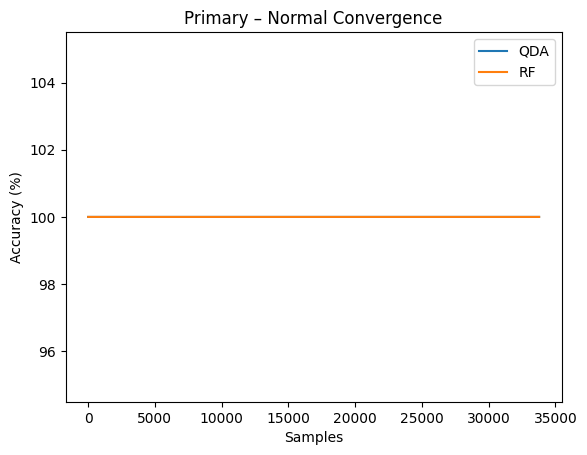

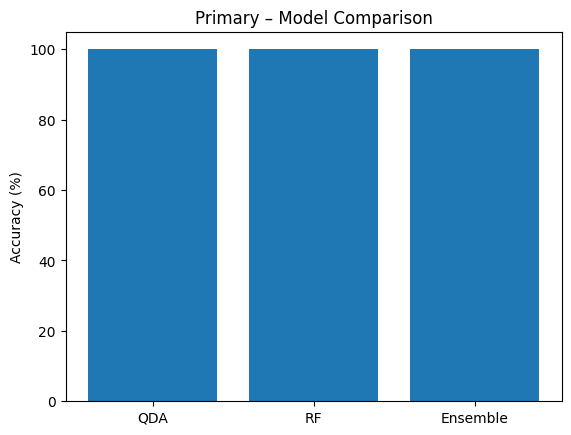

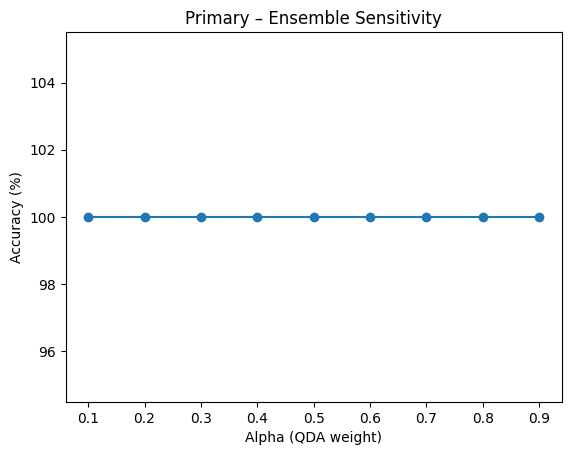


📊 Processing label: Fault Location
✅ Confusion matrix written: Fault_Location


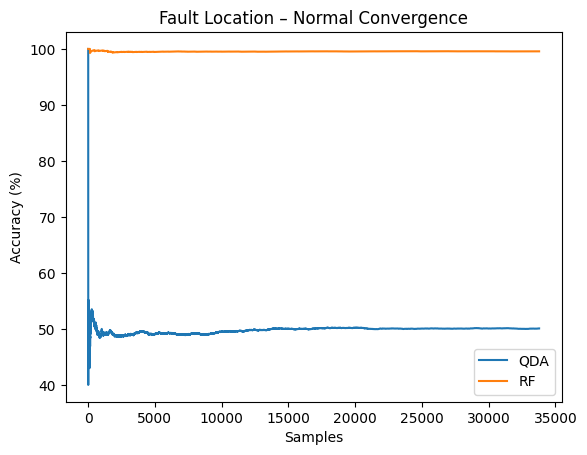

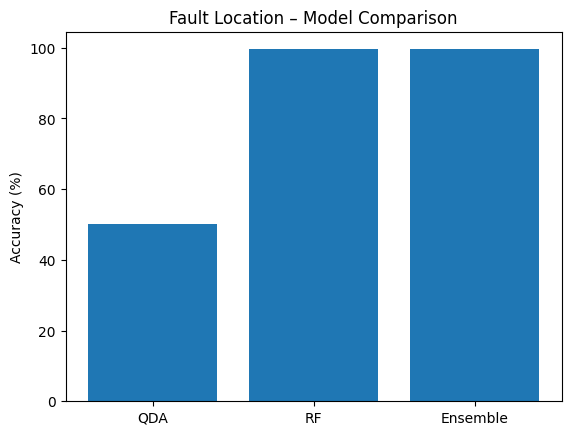

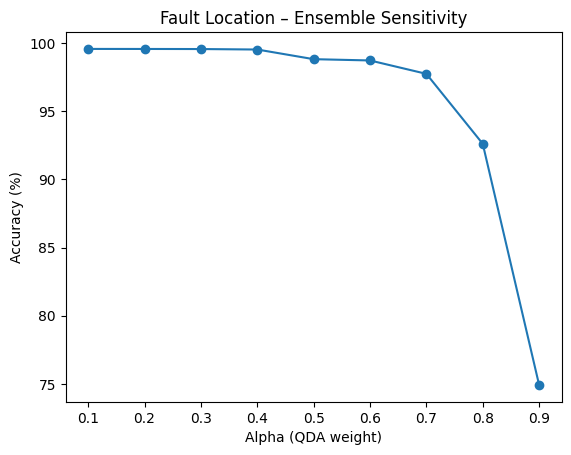


📊 Processing label: Fault Line
✅ Confusion matrix written: Fault_Line


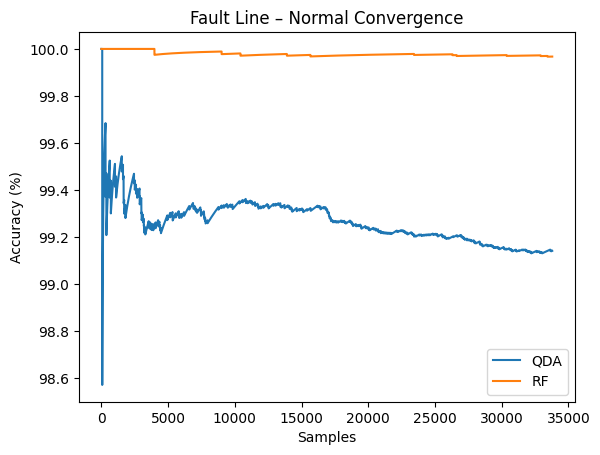

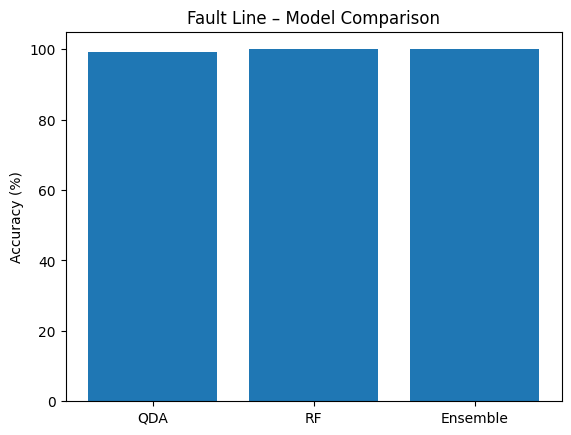

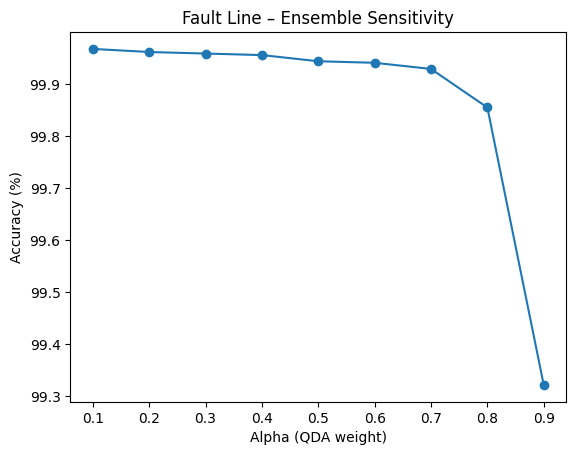


📊 Processing label: CCT_Class
✅ Confusion matrix written: CCT_Class


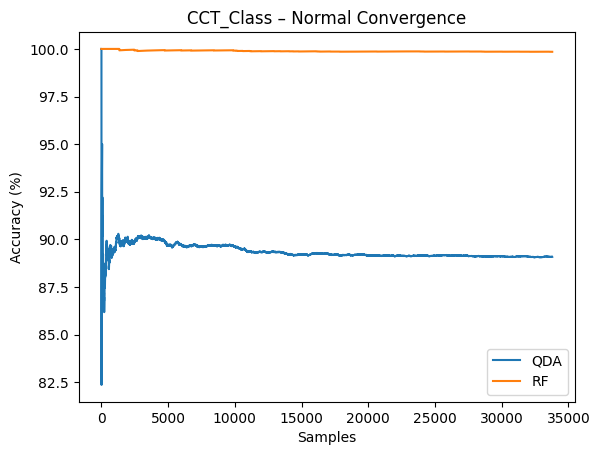

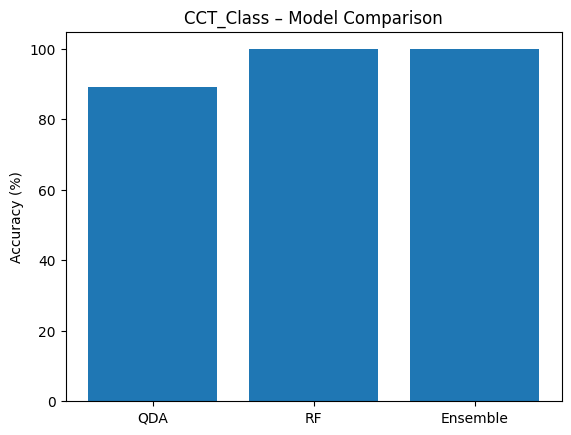

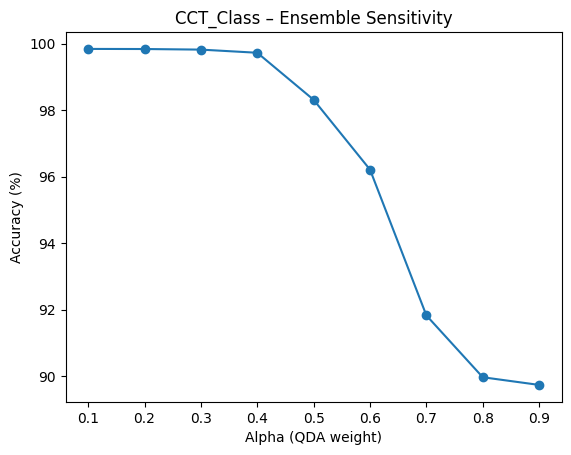


🎯 ALL LABELS PROCESSED SUCCESSFULLY
📁 Excel saved at: E:\WOU_BITS INTERN\39 BUS SYSTEM\Model_Results_Presentation.xlsx


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# ==================================================
# SAVE PATH (SAME AS INPUT FILE)
# ==================================================
BASE_DIR = r"E:\WOU_BITS INTERN\39 BUS SYSTEM"
OUTPUT_FILE = os.path.join(BASE_DIR, "Model_Results_Presentation.xlsx")

writer = pd.ExcelWriter(OUTPUT_FILE, engine="xlsxwriter")

accuracy_rows = []

# ==================================================
# LOOP FOR ALL LABELS (FORCED)
# ==================================================
for label in LABELS:

    print(f"\n📊 Processing label: {label}")

    # ---------- Encode label (actual system IDs preserved) ----------
    le = LabelEncoder()
    y = le.fit_transform(df[label])
    class_names = le.classes_   # REAL labels: 1–68, 1–99, 1–34, CCT ranges

    # ---------- Same split ----------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        stratify=y,
        random_state=42
    )

    # ---------- Same models ----------
    qda = QuadraticDiscriminantAnalysis(reg_param=0.8)
    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    qda.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    qda_prob = qda.predict_proba(X_test)
    rf_prob = rf.predict_proba(X_test)

    qda_pred = np.argmax(qda_prob, axis=1)
    rf_pred = np.argmax(rf_prob, axis=1)

    # ---------- Ensemble ----------
    best_acc, best_alpha = 0, 0
    for a in np.arange(0.1, 1.0, 0.1):
        ens_pred = np.argmax(a * qda_prob + (1 - a) * rf_prob, axis=1)
        acc = accuracy_score(y_test, ens_pred)
        if acc > best_acc:
            best_acc = acc
            best_alpha = a
            best_ens_pred = ens_pred

    # ==================================================
    # CONFUSION MATRIX (REAL LABELS)
    # ==================================================
    cm = confusion_matrix(y_test, best_ens_pred)

    cm_df = pd.DataFrame(
        cm,
        index=class_names,
        columns=class_names
    )

    sheet_name = label.replace(" ", "_")[:31]
    cm_df.to_excel(writer, sheet_name=sheet_name)

    print(f"✅ Confusion matrix written: {sheet_name}")

    # ==================================================
    # ACCURACY TABLE
    # ==================================================
    accuracy_rows.append([
        label,
        accuracy_score(y_test, qda_pred) * 100,
        accuracy_score(y_test, rf_pred) * 100,
        best_acc * 100
    ])

    # ==================================================
    # CONVERGENCE GRAPH 1 – NORMAL
    # ==================================================
    plt.figure()
    plt.plot(
        np.cumsum(qda_pred == y_test) / np.arange(1, len(y_test) + 1) * 100,
        label="QDA"
    )
    plt.plot(
        np.cumsum(rf_pred == y_test) / np.arange(1, len(y_test) + 1) * 100,
        label="RF"
    )
    plt.xlabel("Samples")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{label} – Normal Convergence")
    plt.legend()
    plt.show()

    # ==================================================
    # CONVERGENCE GRAPH 2 – QDA vs RF vs ENS
    # ==================================================
    plt.figure()
    plt.bar(
        ["QDA", "RF", "Ensemble"],
        [
            accuracy_score(y_test, qda_pred) * 100,
            accuracy_score(y_test, rf_pred) * 100,
            best_acc * 100
        ]
    )
    plt.ylabel("Accuracy (%)")
    plt.title(f"{label} – Model Comparison")
    plt.show()

    # ==================================================
    # CONVERGENCE GRAPH 3 – ALPHA vs ACCURACY
    # ==================================================
    alpha_vals = np.arange(0.1, 1.0, 0.1)
    alpha_acc = []

    for a in alpha_vals:
        p = np.argmax(a * qda_prob + (1 - a) * rf_prob, axis=1)
        alpha_acc.append(accuracy_score(y_test, p) * 100)

    plt.figure()
    plt.plot(alpha_vals, alpha_acc, marker='o')
    plt.xlabel("Alpha (QDA weight)")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{label} – Ensemble Sensitivity")
    plt.show()

# ==================================================
# SAVE SUMMARY
# ==================================================
summary_df = pd.DataFrame(
    accuracy_rows,
    columns=["Label", "QDA (%)", "RF (%)", "Ensemble (%)"]
)
summary_df.to_excel(writer, sheet_name="Accuracy_Summary", index=False)

writer.close()

print("\n🎯 ALL LABELS PROCESSED SUCCESSFULLY")
print(f"📁 Excel saved at: {OUTPUT_FILE}")

In [32]:
MODEL_STORE[label] = {
    "y_test": y_test,
    "y_pred": y_pred,          # final selected model prediction
    "label_encoder": le        # encoder used for that label
}


CONFUSION MATRIX FOR: CCT_Class
           1.58–1.69  1.69–1.78  2.00–2.50
1.58–1.69      14249         16          0
1.69–1.78         10      16505          1
2.00–2.50          0         24       2979


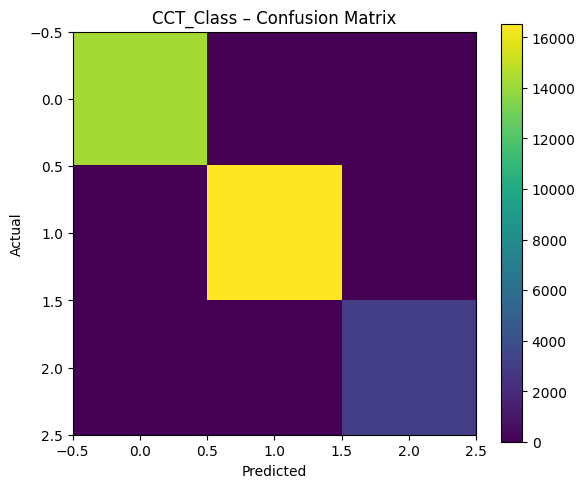


✅ CONFUSION MATRICES DISPLAYED & SAVED
📁 Excel file saved at: E:\WOU_BITS INTERN\39 BUS SYSTEM\Model_Results_Presentation.xlsx


In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ==================================================
# SAVE PATH (SAME FOLDER AS INPUT DATA)
# ==================================================
BASE_DIR = r"E:\WOU_BITS INTERN\39 BUS SYSTEM"
OUT_FILE = os.path.join(BASE_DIR, "Model_Results_Presentation.xlsx")

writer = pd.ExcelWriter(OUT_FILE, engine="xlsxwriter")

# ==================================================
# LOOP ONLY FOR VISUALIZATION (NO TRAINING)
# ==================================================
for label, res in MODEL_STORE.items():

    print("\n===================================")
    print(f"CONFUSION MATRIX FOR: {label}")
    print("===================================")

    y_test = res["y_test"]
    y_pred = res["y_pred"]
    le = res["label_encoder"]

    class_names = le.classes_   # REAL labels (1–68, 1–99, 1–34, CCT ranges)

    # ==================================================
    # CONFUSION MATRIX (NUMERIC)
    # ==================================================
    cm = confusion_matrix(y_test, y_pred)

    cm_df = pd.DataFrame(
        cm,
        index=class_names,
        columns=class_names
    )

    # -------- print small preview --------
    print(cm_df.head())

    # ==================================================
    # SAVE TO EXCEL
    # ==================================================
    sheet_name = label.replace(" ", "_")[:31]
    cm_df.to_excel(writer, sheet_name=sheet_name)

    # ==================================================
    # VISUAL CONFUSION MATRIX (PLOT)
    # ==================================================
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{label} – Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

writer.close()

print("\n✅ CONFUSION MATRICES DISPLAYED & SAVED")
print(f"📁 Excel file saved at: {OUT_FILE}")

Backup

In [36]:
import pandas as pd
import numpy as np
import warnings
import os                      

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error,
    confusion_matrix
)

In [38]:
# ==================================================
# 1. LOAD DATA
# ==================================================
file_path = r"E:\WOU_BITS INTERN\39 BUS SYSTEM\39 BUS SYSTEM FAULT.xlsx"
df = pd.read_excel(file_path)

In [39]:
# ==================================================
# 2. DEFINE FEATURES AND LABELS
# ==================================================
FEATURES = [
    "Phase Voltage A/Terminal in kV",
    "Phase Voltage B/Terminal in kV",
    "Phase Voltage C/Terminal in kV",
    "Phase Current A/Terminal in kA",
    "Phase Current B/Terminal in kA",
    "Phase Current C/Terminal in kA",
    "Terminal/Bus"
]

LABELS = [
    "Primary",
    "Fault Location",
    "CCT",
    "Fault Line",
    "B1", "B2", "B3", "B4"
]

X = df[FEATURES]

# ==================================================
# 3. FEATURE SCALING
# ==================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==================================================
# 4. FINAL RESULT STORAGE
# ==================================================
final_summary = {}

In [58]:
LABELS

['Primary', 'Fault Location', 'CCT', 'Fault Line', 'B1', 'B2', 'B3', 'B4']

In [66]:
# ==================================================
# LOOP FOR EACH LABEL
# ==================================================
for label in LABELS:

    print("\n-----------------------------------------------")
    print(f"LABEL: {label}")
    print("-----------------------------------------------")

    y = LabelEncoder().fit_transform(df[label])

    if len(np.unique(y)) < 2:
        print("❌ Only one class present — skipped")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.25,
        random_state=42,
        stratify=y
    )

    # ---------------------------------------------
    # QDA MODEL
    # ---------------------------------------------
    qda = QuadraticDiscriminantAnalysis(reg_param=0.8)
    qda.fit(X_train, y_train)
    qda_prob = qda.predict_proba(X_test)
    qda_pred = np.argmax(qda_prob, axis=1)

    acc_qda = accuracy_score(y_test, qda_pred) * 100

    # ---------------------------------------------
    # RANDOM FOREST MODEL
    # ---------------------------------------------
    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_prob = rf.predict_proba(X_test)
    rf_pred = np.argmax(rf_prob, axis=1)

    acc_rf = accuracy_score(y_test, rf_pred) * 100

    # ---------------------------------------------
    # ENSEMBLE (AUTO α SEARCH)
    # ---------------------------------------------
    best_alpha = None
    best_ens_acc = 0
    best_ens_prob = None
    best_ens_pred = None

    for alpha in np.arange(0.1, 1.0, 0.1):
        ens_prob = alpha * qda_prob + (1 - alpha) * rf_prob
        ens_pred = np.argmax(ens_prob, axis=1)
        acc = accuracy_score(y_test, ens_pred) * 100

        if acc > best_ens_acc:
            best_ens_acc = acc
            best_alpha = alpha
            best_ens_prob = ens_prob
            best_ens_pred = ens_pred

    # ---------------------------------------------
    # MODEL SELECTION
    # ---------------------------------------------
    scores = {
        "QDA": acc_qda,
        "Random Forest": acc_rf,
        "Ensemble": best_ens_acc
    }

    best_model = max(scores, key=scores.get)

    # ---------------------------------------------
    # FINAL METRICS (BEST MODEL ONLY)
    # ---------------------------------------------
    if best_model == "QDA":
        y_pred = qda_pred
        y_prob = qda_prob
    elif best_model == "Random Forest":
        y_pred = rf_pred
        y_prob = rf_prob
    else:
        y_pred = best_ens_pred
        y_prob = best_ens_prob

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average="weighted") * 100
    rec = recall_score(y_test, y_pred, average="weighted") * 100
    f1 = f1_score(y_test, y_pred, average="weighted") * 100
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr") * 100
    except:
        roc_auc = None

    # ---------------------------------------------
    # PRINT RESULTS
    # ---------------------------------------------
    print(f"QDA Accuracy        : {acc_qda:.2f}%")
    print(f"RF Accuracy         : {acc_rf:.2f}%")
    print(f"Ensemble Accuracy   : {best_ens_acc:.2f}% (alpha={best_alpha})")
    print(f"✅ SELECTED MODEL   : {best_model}")

    print("\n--- FINAL METRICS (Selected Model) ---")
    print(f"Accuracy (%)   : {acc:.2f}")
    print(f"Precision (%)  : {prec:.2f}")
    print(f"Recall (%)     : {rec:.2f}")
    print(f"F1-score (%)   : {f1:.2f}")
    print(f"ROC-AUC (%)    : {roc_auc:.2f}" if roc_auc else "ROC-AUC : Not defined")
    print(f"MAE            : {mae:.4f}")
    print(f"MSE            : {mse:.4f}")
    print(f"RMSE           : {rmse:.4f}")

    final_summary[label] = {
        "Best Model": best_model,
        "QDA Acc": acc_qda,
        "RF Acc": acc_rf,
        "ENS Acc": best_ens_acc
    }

# ==================================================
# FINAL SUMMARY
# ==================================================
print("\n🎯 FINAL MODEL SELECTION SUMMARY")
print("================================")
for lbl, res in final_summary.items():
    print(
        f"{lbl:15s} → {res['Best Model']:12s} | "
        f"QDA={res['QDA Acc']:.2f}% | "
        f"RF={res['RF Acc']:.2f}% | "
        f"ENS={res['ENS Acc']:.2f}%"
    )

print("\n✅ AUTOMATIC QDA / RF / ENSEMBLE SELECTION COMPLETED")


-----------------------------------------------
LABEL: Primary
-----------------------------------------------
QDA Accuracy        : 41.93%
RF Accuracy         : 99.58%
Ensemble Accuracy   : 99.62% (alpha=0.1)
✅ SELECTED MODEL   : Ensemble

--- FINAL METRICS (Selected Model) ---
Accuracy (%)   : 99.62
Precision (%)  : 99.62
Recall (%)     : 99.62
F1-score (%)   : 99.62
ROC-AUC (%)    : 100.00
MAE            : 0.0118
MSE            : 0.1910
RMSE           : 0.4370

-----------------------------------------------
LABEL: Fault Location
-----------------------------------------------
QDA Accuracy        : 57.04%
RF Accuracy         : 99.69%
Ensemble Accuracy   : 99.65% (alpha=0.1)
✅ SELECTED MODEL   : Random Forest

--- FINAL METRICS (Selected Model) ---
Accuracy (%)   : 99.69
Precision (%)  : 99.69
Recall (%)     : 99.69
F1-score (%)   : 99.69
ROC-AUC : Not defined
MAE            : 0.0031
MSE            : 0.0031
RMSE           : 0.0555

-----------------------------------------------
LAB

In [50]:
import matplotlib.pyplot as plt

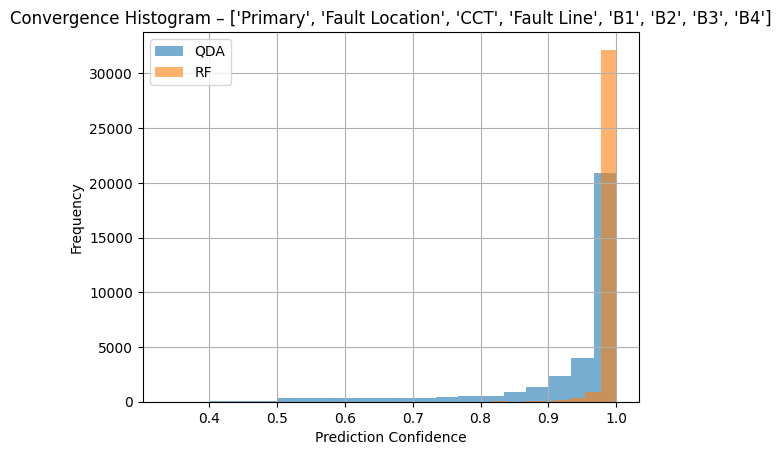

In [68]:
# ==================================================
# CONVERGENCE HISTOGRAM (QDA vs RF)
# ==================================================
plt.figure()
plt.hist(np.max(qda_prob, axis=1), bins=20, alpha=0.6, label="QDA")
plt.hist(np.max(rf_prob, axis=1), bins=20, alpha=0.6, label="RF")
plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title(f"Convergence Histogram – {LABELS}")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
LABELS

['Primary', 'Fault Location', 'CCT', 'Fault Line', 'B1', 'B2', 'B3', 'B4']

AttributeError: Rectangle.set() got an unexpected keyword argument 'LABELS'

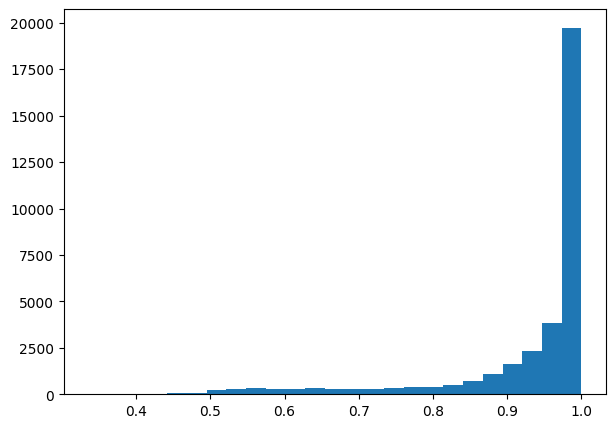

In [86]:
# ==================================================
# CONVERGENCE HISTOGRAM (QDA vs RF) — PER LABEL
# ==================================================
plt.figure(figsize=(7, 5))

plt.hist(
    np.max(qda_prob, axis=1),
    bins=25,
    alpha=0.6,
    LABELS="QDA Confidence"
)

plt.hist(
    np.max(rf_prob, axis=1),
    bins=25,
    alpha=0.6,
    LABELS="RF Confidence"
)

plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title(f"Convergence Histogram – {LABELS}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.close()   # 🔥 THIS IS THE KEY LINE
print("Plot generated for:", LABELS)

In [76]:
from IPython.display import display

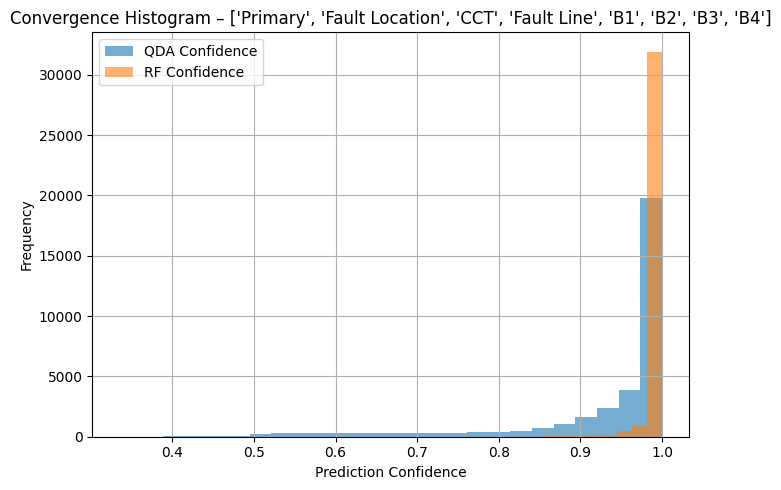

In [82]:
# ==================================================
# CONVERGENCE HISTOGRAM (QDA vs RF) — DISPLAY ONLY
# ==================================================
fig = plt.figure(figsize=(7, 5))

plt.hist(
    np.max(qda_prob, axis=1),
    bins=25,
    alpha=0.6,
    label="QDA Confidence"
)

plt.hist(
    np.max(rf_prob, axis=1),
    bins=25,
    alpha=0.6,
    label="RF Confidence"
)

plt.xlabel("Prediction Confidence")
plt.ylabel("Frequency")
plt.title(f"Convergence Histogram – {LABELS}")
plt.legend()
plt.grid(True)
plt.tight_layout()

display(fig)   # 🔥 FORCE DISPLAY FOR EACH LABEL
plt.close(fig)